# 6 Seq2Seq with Convolutional Encoder

This notebook trains and evaluates the amended Seq2Seq model with a convolutional encoder.

## Import libraries

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from comms import awgn, make_rrc, modulate, demodulate, pulse_shape

## Functions

In [2]:
def gen_data(num_examples, seq_length, mod_order=4, sps=4, span=10, snr=50, normalize=True):
    '''
    This function produces a num_examples number of pulse shaped M-QAM waveforms, each
    example is made up from seq_length*sps samples.
    '''
    
    # Calculate number of weights based on sps and span, and create an RRC filter
    num_weights= sps*span+1
    hrrc = make_rrc(num_weights=num_weights, fs=sps)
    
    # Generate random bits
    ints = np.random.randint(low=0, high=mod_order, size=(num_examples * seq_length))
    
    # Modulate according to mod order
    samples = modulate(ints, M=mod_order)
    
    # Pulse shape / upsample the symbols
    samples_pulse_shaped = pulse_shape(samples, hrrc, sps=sps)
    
    # Add noise. IMPORTANT -> measured=True (keep note of this when eveluating)
    samples_noisy = awgn(samples_pulse_shaped, snr, measured=True)
    
    # Reshape the vectors into a new array of shape [num_examples, seq_length]
    data = samples_noisy.reshape(num_examples,-1)
    labels = ints.reshape(num_examples,-1)
    
    # Optionally normalize the waveform (helps with training)
    if normalize:
        data = (data/np.max(np.abs(data),axis=1)[:,None])
    
    return data, labels

def to_tensors(x,y, onehot=False, gpu=False, batch_first=False, normalize=True, num_classes=None, conv_compatible=False):
    '''
    This function takes the outputs from gen_data and does the necessary formatting
    to make the data compatible with torch nn layers.
    '''
    
    # Split complex x into real/imaginary along 3rd axis
    # 2d -> 3d tensor
    x = torch.FloatTensor(np.stack((x.real, x.imag), axis=2))
    
    # conv1d expects (N, channel_in, length) shape
    if conv_compatible:
        x = x.permute((0,2,1))
    
    # One hot encoding if doing MSE/CrossEntropy
    # Otherwise NLLLoss will take the LongTensor
    if onehot:
        y = torch.LongTensor(y)
        if num_classes:
            y = F.one_hot(y, num_classes=num_classes)
        else:
            y = F.one_hot(y, num_classes=len(np.unique(y)))
    else:
        y = torch.LongTensor(y)
        
    # LSTM expects (seq, batch, feats) input shape
    if not batch_first:
        x = x.permute((1,0,2))
        if onehot:
            y = y.permute((1,0,2))
        else:
            y = y.unsqueeze(2).permute((1,0,2))
    
    # Move to cuda device memory if gpu is used
    if gpu:
        x = x.cuda()
        y = y.cuda()
    
    return x,y

## Architecture

In [26]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, device='cpu', dropout=0):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout)

    def forward(self, input):
        
        output, hidden = self.rnn(input)
        
        return output, hidden
    
    def initHidden(self, batch_size=32, device='cpu'):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device), 
                torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
    

class EncoderConvRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, device='cpu', num_filters=16, dropout=0):
        super(EncoderConvRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        
        self.conv1 = nn.Conv1d(2, num_filters, 9, padding=4)
        self.conv2 = nn.Conv1d(num_filters, 8, 9)
        self.maxpool = nn.MaxPool1d(2)

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = x.permute(0,2,1)
#         x = x.permute(2,0,1)
        
        output, hidden = self.rnn(x)
        
        return output, hidden
    
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, device='cpu', dropout=0):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers=num_layers, dropout=dropout)
        self.out = nn.Linear(hidden_size, input_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        rnn_output, hidden = self.rnn(input, hidden)
        
        rnn_output = self.dropout(rnn_output)
        y = self.out(rnn_output)
        
        return y, hidden

## Training

Define the training and validation functions for one epoch.

In [36]:
def gen_dataset(data_config, train_config, conv_compatible=False):
    
    # if multiple SNR
    if type(data_config['snr']) == np.ndarray:
        datas, labels = [], []
        for sn in data_config['snr']:
            x_bpsk, y_bpsk = gen_data(data_config['num_examples_bpsk'],
                              data_config['seq_length'],
                              sps=data_config['sps'],
                              mod_order=2,
                              snr=sn)
            
            x_qpsk, y_qpsk = gen_data(data_config['num_examples_qpsk'],
                              data_config['seq_length'],
                              sps=data_config['sps'],
                              mod_order=4,
                              snr=sn)
            
            y_qpsk += 2
            
            datas.append(x_bpsk)
            datas.append(x_qpsk)
            labels.append(y_bpsk)
            labels.append(y_qpsk)

        x = np.concatenate((datas))
        y = np.concatenate((labels))
    
    # if single SNR
    else:
        x_bpsk, y_bpsk = gen_data(data_config['num_examples_bpsk'], 
                                  data_config['seq_length'], 
                                  mod_order=2, sps=data_config['sps'], 
                                  snr=data_config['snr'])

        x_qpsk, y_qpsk = gen_data(data_config['num_examples_qpsk'], 
                                  data_config['seq_length'], 
                                  mod_order=4, sps=data_config['sps'], 
                                  snr=data_config['snr'])
        y_qpsk += 2
        x = np.concatenate((x_bpsk, x_qpsk))
        y = np.concatenate((y_bpsk, y_qpsk))

    x, y = to_tensors(x, y, batch_first=True, gpu=True, onehot=True, num_classes=6, conv_compatible=conv_compatible)

    train_dataset = torch.utils.data.TensorDataset(x, y)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
    
    return train_dataloader

def train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, tf_ratio=0, gpu=True, num_classes=6, conv=False):
    
    batch_size = x_train.shape[0]
    seq_length = y_train.shape[1]
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # format to (seq x batch x feats) format
    if not conv:
        x_train = x_train.permute((1,0,2))
    y_train = y_train.permute((1,0,2))

    loss = 0

    _, encoder_hidden = encoder(x_train)

    decoder_hidden = encoder_hidden

    decoder_input = torch.zeros((1,batch_size,num_classes))
        
    if gpu:
        decoder_input = decoder_input.cuda()

    for i in range(seq_length):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
        loss += criterion(y.squeeze(), y_train[i].argmax(axis=1)) # cross entropy

        teacher_forcing = np.random.random() < tf_ratio
        if teacher_forcing:
            decoder_input = y_train[i].float().unsqueeze(0)
        else:
            decoder_input = y

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()/y_train.shape[0]

def val_step(x_val, y_val, encoder, decoder, criterion, gpu=True, num_classes=6, conv=False):
    
    batch_size = x_val.shape[0]
    
    if not conv:
        x_val = x_val.permute((1,0,2))
    y_val = y_val.permute((1,0,2))

    loss = 0

    _, encoder_hidden = encoder(x_val)

    decoder_hidden = encoder_hidden

    decoder_input = torch.zeros((1,batch_size,num_classes))
    if gpu:
        decoder_input = decoder_input.cuda()

    for i in range(y_val.shape[0]):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
#         loss += criterion(y.squeeze(), y_val[i].squeeze().float()) #mse
        loss += criterion(y.squeeze(), y_val[i].argmax(axis=1)) # cross-entropy
        decoder_input = y
    
    return loss.item()/y_val.shape[0]

def inference(x_test, encoder, decoder, num_classes=6, seq_length=5, batch_size=32):
        
#     encoder_hidden = encoder.initHidden()

#     encoder_hidden = encoder.initHidden(batch_size=batch_size)
    _, encoder_hidden = encoder(x_test)

    decoder_hidden = encoder_hidden

    decoder_outputs = torch.zeros((seq_length,batch_size,num_classes))
    decoder_input = torch.zeros((1,batch_size,num_classes))
    
    for i in range(seq_length):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
        decoder_outputs[i] = y
        decoder_input = y
        
    return decoder_outputs

def eval_accuracy(encoder, decoder, snr_range, mod_order=2, num_examples=256, seq_length=5, 
                  sps=4, num_classes=6, batch_size=32, conv=False):
    
    accuracies = []
    
    for snr in snr_range:

        x, y = gen_data(num_examples, seq_length, mod_order=mod_order, sps=sps, snr=snr)
        if mod_order == 4:
            y += 2
        if mod_order == 8:
            y += 6
        x,y = to_tensors(x, y, batch_first=True, conv_compatible=conv)

        # create dataset and dataloader
        test_dataset = torch.utils.data.TensorDataset(x, y)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

        corrects, totals = 0, 0
        for x,y in test_dataloader:
            # x = x.permute((1,0,2))
            y = y.unsqueeze(2).permute((1,0,2))
            y_hat = inference(x, encoder, decoder, num_classes=num_classes, seq_length=seq_length)

            corrects += torch.sum(y_hat.argmax(axis=2) == y.squeeze())

            totals += y.numel()

        accuracy = np.array(corrects)/totals

        accuracies.append(accuracy)
    
    return accuracies

In [5]:
def gen_validation_dataloader(snrs, seq_length, examples_per_snr=32):
    ## bpsk
    datas, labels = [], []
    for snr in snrs:
        x_bpsk, y_bpsk = gen_data(examples_per_snr, seq_length, mod_order=2, sps=4, snr=snr)
        datas.append(x_bpsk)
        labels.append(y_bpsk)
        
    x_bpsk = np.concatenate((datas))
    y_bpsk = np.concatenate((labels))

    x_val_bpsk, y_val_bpsk = to_tensors(x_bpsk, y_bpsk, batch_first=True, gpu=True, onehot=True, num_classes=6,conv_compatible=True)
    val_dataloader_bpsk = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val_bpsk, y_val_bpsk), batch_size=32, shuffle=True)

    ## qpsk
    datas, labels = [], []
    for snr in snrs:
        x_qpsk, y_qpsk = gen_data(examples_per_snr, seq_length, mod_order=4, sps=4, snr=snr)
        datas.append(x_qpsk)
        labels.append(y_qpsk)
        
    x_qpsk = np.concatenate((datas))
    y_qpsk = np.concatenate((labels))
    y_qpsk += 2

    x_val_qpsk, y_val_qpsk = to_tensors(x_qpsk, y_qpsk, batch_first=True, gpu=True, onehot=True, num_classes=6, conv_compatible=True)
    val_dataloader_qpsk = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val_qpsk, y_val_qpsk), batch_size=32, shuffle=True)

    return val_dataloader_bpsk, val_dataloader_qpsk

## Train and evaluate

In [19]:
data_config = {'snr': np.arange(-5,21,5),
               'num_examples_bpsk': 2048,
               'num_examples_qpsk': 2048,
               'seq_length': 5,
               'sps': 4,
               'span': 10,
               'num_examples_val': 256}

train_config = {'num_epochs': 250,
                'batch_size': 64,
                'learning_rate': 3e-4,
                'weight_decay': 0.0001,
                'device': 'cuda',
                'tf_ratio': 0}

model_config = {'hidden_size': 16,
                'num_layers': 2,
                'input_size': 8,
                'output_size': 6}

In [44]:
seq_lengths = [5, 10, 15, 20]
model_configs = [(16,2), (128,2)]
gpu = True

for model_config in model_configs:
    for seq_length in seq_lengths:
        print(seq_length)
        data_config['seq_length'] = seq_length
        
        np.random.seed(0)
        train_dataloader = gen_dataset(data_config, train_config, conv_compatible=True)
        val_dataloader_bpsk, val_dataloader_qpsk = gen_validation_dataloader(data_config['snr'], seq_length)

        criterion = nn.CrossEntropyLoss()

        torch.manual_seed(0)
        
        # Create the encoder and decoder models
        encoder = EncoderConvRNN(hidden_size=model_config[0], input_size=8, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
        decoder = DecoderRNN(hidden_size=model_config[0], input_size=6, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')

        encoder.cuda()
        decoder.cuda()

        # Initialize the optimizers
        encoder_optimizer = optim.Adam(encoder.parameters(), lr=3e-4, weight_decay=0.0001)
        decoder_optimizer = optim.Adam(decoder.parameters(), lr=3e-4, weight_decay=0.0001)

        # Define empty lists where loss progress will be stored
        losses, val_losses, val_losses_bpsk, val_losses_qpsk = [], [], [], []

        best_loss = np.inf

        # Training loop
        for epoch in range(train_config['num_epochs']):
            train_loss = 0
            for x_train,y_train in train_dataloader:

                train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, gpu=gpu, conv=True)

            losses.append(train_loss/len(train_dataloader))

            with torch.no_grad():
                val_loss = 0
                for x_val,y_val in val_dataloader_bpsk:
                    val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu, conv=True)
                val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))

                val_loss = 0
                for x_val,y_val in val_dataloader_qpsk:
                    val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu, conv=True)
                val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))

                val_loss = (val_losses_bpsk[-1] + val_losses_qpsk[-1])/2
                val_losses.append(val_loss)

                if val_loss < best_loss:
                    encoder_weights = encoder.state_dict()
                    decoder_weights = decoder.state_dict()
                    best_loss = val_losses[-1]
                    print(f"{epoch}: Best loss {best_loss}, saving...")

        encoder.load_state_dict(encoder_weights)
        decoder.load_state_dict(decoder_weights)
        
        train_results = {'encoder': encoder_weights,
                        'decoder': decoder_weights,
                        'losses': losses,
                        'val_losses': val_losses,
                        'val_losses_bpsk': val_losses_bpsk,
                        'val_losses_qpsk': val_losses_qpsk}
        
        torch.save(train_results, f"models/conv/conv_bpsk_qpsk_{model_config[0]}_{model_config[1]}_seq_{data_config['seq_length']}_trained_on_2048.pt")

5
0: Best loss 1.1733760277430216, saving...
1: Best loss 1.0727361996968587, saving...
2: Best loss 0.9690527677536012, saving...
3: Best loss 0.9314283967018127, saving...
4: Best loss 0.912697466214498, saving...
5: Best loss 0.8548606117566427, saving...
6: Best loss 0.7449309508005777, saving...
7: Best loss 0.6320814390977224, saving...
8: Best loss 0.5054088900486629, saving...
9: Best loss 0.46798329055309296, saving...
10: Best loss 0.42809632619222004, saving...
11: Best loss 0.3815147082010905, saving...
12: Best loss 0.3346120660503705, saving...
14: Best loss 0.333273317416509, saving...
15: Best loss 0.3080309063196182, saving...
16: Best loss 0.28677943150202434, saving...
17: Best loss 0.27714933951695764, saving...
22: Best loss 0.2632182891170184, saving...
23: Best loss 0.24927527209122974, saving...
24: Best loss 0.234038141866525, saving...
28: Best loss 0.2241744856039683, saving...
30: Best loss 0.21362448334693906, saving...
33: Best loss 0.2109797184665998, sav

### With dropout

In [27]:
seq_lengths = [10, 15, 20]
model_configs = [(16,2), (128,2)]
dropouts = [0.25, 0.5]
gpu = True

for dropout in dropouts:
    for model_config in model_configs:
        for seq_length in seq_lengths:
            print(seq_length)
            data_config['seq_length'] = seq_length
            
            np.random.seed(0)
            train_dataloader = gen_dataset(data_config, train_config, conv_compatible=True)
            val_dataloader_bpsk, val_dataloader_qpsk = gen_validation_dataloader(data_config['snr'], seq_length)

            criterion = nn.CrossEntropyLoss()

            torch.manual_seed(0)
            
            # Create the encoder and decoder models
            encoder = EncoderConvRNN(hidden_size=model_config[0], input_size=8, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu', dropout=dropout)
            decoder = DecoderRNN(hidden_size=model_config[0], input_size=6, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu', dropout=dropout)

            encoder.cuda()
            decoder.cuda()

            # Initialize the optimizers
            encoder_optimizer = optim.Adam(encoder.parameters(), lr=3e-4, weight_decay=0.0001)
            decoder_optimizer = optim.Adam(decoder.parameters(), lr=3e-4, weight_decay=0.0001)

            # Define empty lists where loss progress will be stored
            losses, val_losses, val_losses_bpsk, val_losses_qpsk = [], [], [], []

            best_loss = np.inf

            # Training loop
            for epoch in range(train_config['num_epochs']):
                # Training mode -- enable dropout
                encoder.train()
                decoder.train()
                train_loss = 0
                for x_train,y_train in train_dataloader:

                    train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, gpu=gpu, conv=True)

                losses.append(train_loss/len(train_dataloader))

                with torch.no_grad():
                    # Deactivate dropout layers
                    encoder.eval()
                    decoder.eval()
                    
                    val_loss = 0
                    for x_val,y_val in val_dataloader_bpsk:
                        val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu, conv=True)
                    val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))

                    val_loss = 0
                    for x_val,y_val in val_dataloader_qpsk:
                        val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu, conv=True)
                    val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))

                    val_loss = (val_losses_bpsk[-1] + val_losses_qpsk[-1])/2
                    val_losses.append(val_loss)

                    if val_loss < best_loss:
                        encoder_weights = encoder.state_dict()
                        decoder_weights = decoder.state_dict()
                        best_loss = val_losses[-1]
                        print(f"{epoch}: Best loss {best_loss}, saving...")

            encoder.load_state_dict(encoder_weights)
            decoder.load_state_dict(decoder_weights)
            
            train_results = {'encoder': encoder_weights,
                            'decoder': decoder_weights,
                            'losses': losses,
                            'val_losses': val_losses,
                            'val_losses_bpsk': val_losses_bpsk,
                            'val_losses_qpsk': val_losses_qpsk}
            
            torch.save(train_results, f"models/conv/conv_bpsk_qpsk_{model_config[0]}_{model_config[1]}_seq_{data_config['seq_length']}_trained_on_2048_dropout_{dropout}.pt")

10
0: Best loss 1.1189838210741678, saving...
2: Best loss 1.0951362411181131, saving...
3: Best loss 1.0686046004295349, saving...
4: Best loss 1.0533857703208924, saving...
5: Best loss 1.0298147439956664, saving...
6: Best loss 1.016724975903829, saving...
7: Best loss 0.9991779843966168, saving...
8: Best loss 0.9504311561584474, saving...
9: Best loss 0.9217469692230225, saving...
10: Best loss 0.8950587034225465, saving...
11: Best loss 0.8792484800020853, saving...
12: Best loss 0.8679797252019247, saving...
13: Best loss 0.8640656828880309, saving...
14: Best loss 0.83781844774882, saving...
15: Best loss 0.8228486696879069, saving...
17: Best loss 0.8045187671979268, saving...
18: Best loss 0.7864435712496438, saving...
19: Best loss 0.7652961810429891, saving...
20: Best loss 0.68513738711675, saving...
21: Best loss 0.46364595492680866, saving...
22: Best loss 0.4126427074273427, saving...
23: Best loss 0.3821781143546104, saving...
24: Best loss 0.35604388117790225, saving.

In [38]:
def eval_mod_accuracy(encoder, decoder, snr_range, mod_order=2, num_examples=256, seq_length=5, sps=4, num_classes=6, conv=True):
    
    accuracies = []
    
    for snr in snr_range:

        x, y = gen_data(num_examples, seq_length, mod_order=mod_order, sps=sps, snr=snr)
        if mod_order == 4:
            y += 2
        if mod_order == 8:
            y += 6
        x,y = to_tensors(x,y,batch_first=True,conv_compatible=True)

        # create dataset and dataloader
        test_dataset = torch.utils.data.TensorDataset(x, y)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

        corrects, totals = 0, 0
        for x,y in test_dataloader:
            # x = x.permute((1,0,2))
            y = y.unsqueeze(2).permute((1,0,2))
            y_hat = inference(x, encoder, decoder, num_classes=num_classes)

            if mod_order == 2:
                corrects += torch.sum(y_hat.argmax(axis=2) < 2)
            elif mod_order == 4:
                corrects += torch.sum(sum([y_hat.argmax(axis=2) == val for val in [2,3,4,5]]))
            elif mod_order == 8:
                corrects += torch.sum(y_hat.argmax(axis=2) > 5)

            totals += y.numel()

        accuracy = np.array(corrects)/totals

        accuracies.append(accuracy)
    
    return accuracies

In [41]:
seq_lengths = [10, 15, 20]
model_configs = [(16,2), (128,2)]
dropouts = [0.25, 0.5]
gpu = True

snr_range = np.arange(-30,30)
for model_config in model_configs:
    print(model_config)
    for dropout in dropouts:
        print(dropout)
        for seq_length in seq_lengths:
            # Create the encoder and decoder models
            encoder = EncoderConvRNN(hidden_size=model_config[0], input_size=8, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
            decoder = DecoderRNN(hidden_size=model_config[0], input_size=6, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
            
            encoder.cpu()
            decoder.cpu()
            
            model = torch.load(f"models/conv/conv_bpsk_qpsk_{model_config[0]}_{model_config[1]}_seq_{seq_length}_trained_on_2048_dropout_{dropout}.pt")
            encoder.load_state_dict(model['encoder'])
            decoder.load_state_dict(model['decoder'])

            encoder.eval()
            decoder.eval()
            
            bpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=2, seq_length=seq_length, conv=True)
            qpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=4, seq_length=seq_length, conv=True)
            
            bpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=2, seq_length=seq_length)
            qpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=512, mod_order=4, seq_length=seq_length)
            
            results = {'snr_range': snr_range,
                    'bpsk_accs': bpsk_accs,
                    'qpsk_accs': qpsk_accs,
                    'bpsk_class_accuracy': bpsk_class_accuracy,
                    'qpsk_class_accuracy': qpsk_class_accuracy}
            
            torch.save(results, f"results/conv/conv_bpsk_qpsk_{model_config[0]}_{model_config[1]}_seq_{seq_length}_trained_on_2048_dropout_{dropout}.pt")

(128, 2)
0.25
0.5


## Plotting training results

best val_loss: 0.19072119990984598
best val_loss: 0.1587320665518443
best val_loss: 0.16534746612111728


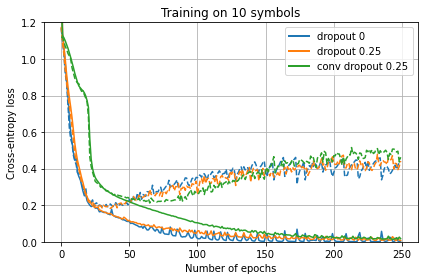

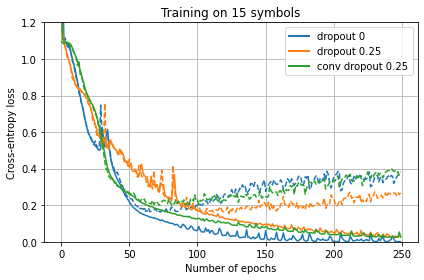

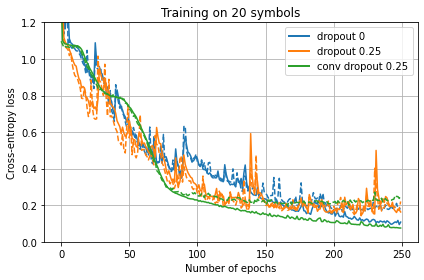

In [5]:
seq_lengths = [10, 15, 20]#, 15, 20]
model_configs = [(128,3)]

for model_config in model_configs:
    for seq_length in seq_lengths:
        plt.figure()
        model = torch.load(f"models/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{seq_length}_trained_on_2048.pt")
        plt.plot(model['losses'], f'C0')
        plt.plot(model['val_losses'], f'C0--')
        print(f"best val_loss: {np.array(model['val_losses']).min()}")

        model = torch.load(f"models/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{seq_length}_trained_on_2048_dropout_0.25.pt")
        plt.plot(model['losses'], f'C1')
        plt.plot(model['val_losses'], f'C1--')

        model = torch.load(f"models/conv/conv_bpsk_qpsk_{model_config[0]}_2_seq_{seq_length}_trained_on_2048_dropout_0.25.pt")
        plt.plot(model['losses'], f'C2')
        plt.plot(model['val_losses'], f'C2--')

        legend_elements = [Line2D([0], [0], color='C0', lw=2, label='weight decay'),
                            Line2D([0], [0], color='C1', lw=2, label='dropout 0.25'),
                            Line2D([0], [0], color='C2', lw=2, label='conv dropout 0.25')]

        plt.legend(legend_elements, ['dropout 0', 'dropout 0.25', 'conv dropout 0.25'])
        plt.ylim([0,1.2])
        plt.grid()
        plt.xlabel('Number of epochs')
        plt.ylabel('Cross-entropy loss')
        plt.title(f'Training on {seq_length} symbols')
        plt.tight_layout()

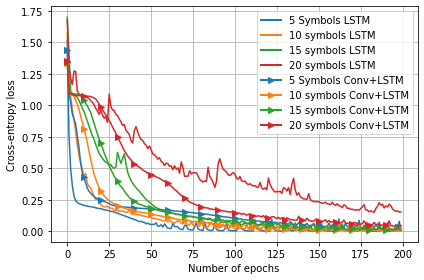

In [2]:
seq_lengths = [5,10, 15, 20]#, 25]#, 15, 20]
model_configs = [(128,3)]#[(16,3), (128,3)]

for jdx, seq_length in enumerate(seq_lengths):
    for idx, model_config in enumerate(model_configs):
        model = torch.load(f"models/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{seq_length}_trained_on_2048.pt")
        plt.plot(model['losses'][:200], f'C{jdx}')
        # plt.plot(model['val_losses'], f'C{jdx}--')

model_configs = [(128,2)]
for jdx, seq_length in enumerate(seq_lengths):
    for idx, model_config in enumerate(model_configs):
        model = torch.load(f"models/conv/conv_bpsk_qpsk_{model_config[0]}_{model_config[1]}_seq_{seq_length}_trained_on_2048.pt")
        plt.plot(model['losses'][:200], f'C{jdx}->', markevery=10)
        # plt.plot(model['val_losses'], f'C{jdx}--')

legend_elements = [Line2D([0], [0], color='C0', lw=2),
                    Line2D([0], [0], color='C1', lw=2),
                    Line2D([0], [0], color='C2', lw=2),
                    Line2D([0], [0], color='C3', lw=2),
                    Line2D([0], [0], color='C0', marker='>', lw=2),
                    Line2D([0], [0], color='C1', marker='>', lw=2),
                    Line2D([0], [0], color='C2', marker='>', lw=2),
                    Line2D([0], [0], color='C3', marker='>', lw=2)]

plt.legend(legend_elements, ['5 Symbols LSTM', '10 symbols LSTM', '15 symbols LSTM', '20 symbols LSTM',
                             '5 Symbols Conv+LSTM', '10 symbols Conv+LSTM', '15 symbols Conv+LSTM', '20 symbols Conv+LSTM'], fontsize=10)
plt.xlabel('Number of epochs')
plt.ylabel('Cross-entropy loss')
plt.grid()
plt.tight_layout()
# plt.savefig('figures/seq2seq_training_losses_only_conv.png', dpi=300, bbox_inches='tight')